<a href="https://colab.research.google.com/github/gg5d/Sequential_GD/blob/main/naive_ANN_with_seq_GD_Colab_extended_NN_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from numpy.random import uniform, randint, randn, normal
import sys
from timeit import default_timer as dt
import matplotlib.pylab as plt
import time

In [16]:
class NeuralNetwork:
    """
    A flexible neural network class that supports configurable architectures.

    Attributes:
        layer_sizes (list): List of integers defining the number of neurons in each layer
                           [input_size, hidden1, hidden2, ..., output_size]
        weights (list): List of weight matrices for each layer
        biases (list): List of bias vectors for each layer
        activations (list): Stores activations during forward pass
    """

    def __init__(self, layer_sizes: list, initialization='normal', seed=None):
        """
        Initialize the neural network with given architecture.

        Args:
            layer_sizes: List of layer sizes, e.g., [2, 2, 3, 4, 4, 4, 2] for 6 hidden layers
            initialization: 'normal' for normal distribution, 'xavier' for Xavier initialization
            seed: Random seed for reproducibility
        """
        if seed is not None:
            np.random.seed(seed)

        self.layer_sizes = layer_sizes
        self.n_layers = len(layer_sizes) - 1  # Number of weight layers
        self.weights = []
        self.biases = []
        self.activations = []

        # Initialize weights and biases
        for i in range(self.n_layers):
            input_size = layer_sizes[i]
            output_size = layer_sizes[i + 1]

            if initialization == 'xavier':
                # Xavier/Glorot initialization
                limit = np.sqrt(6.0 / (input_size + output_size))
                W = np.random.uniform(-limit, limit, (output_size, input_size))
            else:
                # Normal initialization (default)
                W = normal(size=(output_size, input_size))

            b = normal(size=(output_size, 1))

            self.weights.append(W)
            self.biases.append(b)

    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        """Sigmoid activation function."""
        # Clip to prevent overflow
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, a: np.ndarray) -> np.ndarray:
        """Derivative of sigmoid activation function."""
        return a * (1 - a)

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Perform forward pass through the network.

        Args:
            x: Input vector of shape (input_size, 1)

        Returns:
            Output vector of shape (output_size, 1)
        """
        self.activations = [x]  # Store input as first activation

        # Forward pass through all layers
        current_activation = x
        for W, b in zip(self.weights, self.biases):
            z = np.dot(W, current_activation) + b
            current_activation = self.sigmoid(z)
            self.activations.append(current_activation)

        return current_activation

    def backward(self, y: np.ndarray, learning_rate: float, sequential: bool = False):
        """
        Perform backward pass and update weights using backpropagation.

        Args:
            y: True label vector of shape (output_size, 1)
            learning_rate: Learning rate for weight updates
            sequential: If True, update weights immediately after calculating each delta
                       and recalculate subsequent deltas with updated weights.
                       If False, calculate all deltas first, then update all weights.
        """
        if sequential:
            # Sequential GD: Calculate delta and update weights layer by layer (backwards)
            # Start from output layer and work backwards
            current_delta = None

            for i in range(self.n_layers - 1, -1, -1):  # Go from last layer to first
                if i == self.n_layers - 1:
                    # Output layer
                    output = self.activations[-1]
                    current_delta = output * (1 - output) * (output - y)
                else:
                    # Hidden layers: use updated weights from previous iteration
                    activation = self.activations[i + 1]
                    current_delta = (activation * (1 - activation) *
                                    np.dot(self.weights[i + 1].T, current_delta))

                # Update weights and biases for current layer
                prev_activation = self.activations[i]
                self.weights[i] -= learning_rate * current_delta * prev_activation.T
                self.biases[i] -= learning_rate * current_delta

                # Recalculate activation for this layer (for use in next iteration)
                if i > 0:  # Not needed for input layer
                    z = np.dot(self.weights[i], prev_activation) + self.biases[i]
                    self.activations[i + 1] = self.sigmoid(z)
        else:
            # Standard GD: Calculate all deltas first, then update all weights
            output = self.activations[-1]
            deltas = []

            # Calculate output layer delta
            delta = output * (1 - output) * (output - y)
            deltas.append(delta)

            # Backpropagate through hidden layers
            for i in range(self.n_layers - 2, -1, -1):  # Go backwards from second-to-last to first
                delta = (self.activations[i + 1] * (1 - self.activations[i + 1]) *
                        np.dot(self.weights[i + 1].T, deltas[0]))
                deltas.insert(0, delta)

            # Update all weights and biases
            for i in range(self.n_layers):
                delta = deltas[i]
                prev_activation = self.activations[i]

                self.weights[i] -= learning_rate * delta * prev_activation.T
                self.biases[i] -= learning_rate * delta

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Make a prediction for a single input.

        Args:
            x: Input vector of shape (input_size, 1)

        Returns:
            Output vector of shape (output_size, 1)
        """
        return self.forward(x)

    def predict_batch(self, X: np.ndarray) -> np.ndarray:
        """
        Make predictions for multiple inputs.

        Args:
            X: Input matrix of shape (n_samples, input_size) or list of (input_size, 1) vectors

        Returns:
            Output matrix of shape (n_samples, output_size)
        """
        if isinstance(X, list):
            predictions = []
            for x in X:
                pred = self.forward(x)
                predictions.append(pred.ravel())
            return np.array(predictions).T
        else:
            # Assume X is (n_samples, input_size)
            predictions = []
            for i in range(X.shape[0]):
                x = X[i:i+1, :].T  # Convert to column vector
                pred = self.forward(x)
                predictions.append(pred.ravel())
            return np.array(predictions).T

    def compute_cost(self, x1: np.ndarray, x2: np.ndarray, y: np.ndarray) -> float:
        """
        Calculate the cost (error) of the network predictions.

        Args:
            x1, x2: Input feature arrays
            y: True labels of shape (output_size, n_samples)

        Returns:
            Total squared L2 norm of prediction errors
        """
        n_samples = len(x1)
        costvec = np.zeros((n_samples, 1))

        for i in range(n_samples):
            x = np.array([[x1[i]], [x2[i]]])
            output = self.forward(x)
            costvec[i] = np.linalg.norm(output.ravel() - y[:, i], 2)

        return np.linalg.norm(costvec, 2)**2

    def get_weights(self) -> tuple:
        """Return all weights and biases as separate variables (for backward compatibility)."""
        return self.weights, self.biases

    def copy(self):
        """Create a deep copy of the network."""
        new_net = NeuralNetwork(self.layer_sizes)
        new_net.weights = [W.copy() for W in self.weights]
        new_net.biases = [b.copy() for b in self.biases]
        return new_net

    def __repr__(self):
        """String representation of the network."""
        return f"NeuralNetwork(architecture={self.layer_sizes}, n_layers={self.n_layers})"


In [17]:
def activate(x: np.ndarray, W: np.ndarray, b: np.ndarray) -> np.ndarray:
    '''
    Sigmoid activation function for neural network layers.

    Args:
        x: Input vector of shape (input_size, 1)
        W: Weight matrix of shape (output_size, input_size)
        b: Bias vector of shape (output_size, 1)

    Returns:
        Activated output vector of shape (output_size, 1)
    '''
    z = np.dot(W, x) + b
    return 1 / (1 + np.exp(-z))


In [18]:
def cost_function(W2, W3, W4, W5, W6, W7, b2, b3, b4, b5, b6, b7, x1, x2, y):
    '''
    Calculate the cost (error) of the neural network predictions.

    Args:
        W2-W7: Weight matrices for layers 2-7
        b2-b7: Bias vectors for layers 2-7
        x1, x2: Input feature arrays
        y: True labels of shape (2, n_samples)

    Returns:
        Total squared L2 norm of prediction errors
    '''
    n_samples = len(x1)  # Fixed: Use actual dataset size instead of hardcoded 10
    costvec = np.zeros((n_samples, 1))
    x = np.zeros((2, 1))

    for i in range(n_samples):
        x[0, 0], x[1, 0] = x1[i], x2[i]
        a2 = activate(x, W2, b2)
        a3 = activate(a2, W3, b3)
        a4 = activate(a3, W4, b4)
        a5 = activate(a4, W5, b5)
        a6 = activate(a5, W6, b6)
        a7 = activate(a6, W7, b7)

        costvec[i] = np.linalg.norm(a7.ravel() - y[:, i], 2)

    return np.linalg.norm(costvec, 2)**2

In [19]:
def predict(W2, W3, W4, W5, W6, W7, b2, b3, b4, b5, b6, b7, xvec):
    '''
    Perform forward pass through the neural network to generate predictions.

    Args:
        W2-W7: Weight matrices for layers 2-7
        b2-b7: Bias vectors for layers 2-7
        xvec: Input vector of shape (2, 1)

    Returns:
        Network output (activation of layer 7) of shape (2, 1)
    '''
    a2 = activate(xvec, W2, b2)
    a3 = activate(a2, W3, b3)
    a4 = activate(a3, W4, b4)
    a5 = activate(a4, W5, b5)
    a6 = activate(a5, W6, b6)
    a7 = activate(a6, W7, b7)

    return a7


In [32]:
# ========== NEURAL NETWORK INITIALIZATION USING CLASS ==========
# Define the network architecture: [input_size, hidden1, hidden2, ..., output_size]
# Current architecture matches the original: 2 inputs -> 6 hidden layers -> 2 outputs
architecture = [2, 10, 10, 10, 10, 10, 2]  # 6 hidden layers

# Create two networks: one for standard GD, one for sequential GD
nn_gd = NeuralNetwork(architecture, initialization='normal')
nn_seq = nn_gd.copy()  # Create a copy with same initial weights

print("Neural Network Initialized:")
print(f"Architecture: {architecture}")
print(f"Total layers (including input): {len(architecture)}")
print(f"Trainable weight layers: {nn_gd.n_layers}")
print(f"\nLayer details:")
for i, (W, b) in enumerate(zip(nn_gd.weights, nn_gd.biases)):
    print(f"  Layer {i+1}: {W.shape[1]} -> {W.shape[0]} neurons (W: {W.shape}, b: {b.shape})")


Neural Network Initialized:
Architecture: [2, 10, 10, 10, 10, 10, 2]
Total layers (including input): 7
Trainable weight layers: 6

Layer details:
  Layer 1: 2 -> 10 neurons (W: (10, 2), b: (10, 1))
  Layer 2: 10 -> 10 neurons (W: (10, 10), b: (10, 1))
  Layer 3: 10 -> 10 neurons (W: (10, 10), b: (10, 1))
  Layer 4: 10 -> 10 neurons (W: (10, 10), b: (10, 1))
  Layer 5: 10 -> 10 neurons (W: (10, 10), b: (10, 1))
  Layer 6: 10 -> 2 neurons (W: (2, 10), b: (2, 1))


In [33]:
# ========== TRAINING WITH NEURAL NETWORK CLASS ==========
# Training hyperparameters
learning_rate = 0.05
learning_rate_seq = 0.05
Niter = 100000
cost_calc_frequency = 100  # Calculate full cost every N iterations (for efficiency)

# Initialize tracking arrays
cost_value_class = np.zeros((Niter, 1))
cost_value_seq_class = np.zeros((Niter, 1))
diff_output_class = np.zeros((Niter, 1))

print(f"Starting training for {Niter} iterations...")
print(f"Using NeuralNetwork class with architecture: {architecture}")
start_time = time.time()

for counter in range(Niter):
    # Randomly select a training sample (stochastic gradient descent)
    k = randint(y.shape[1])
    xvec = np.array([[x1[k]], [x2[k]]])
    yvec = y[:, k:k+1]  # Keep as column vector

    # ========== STANDARD GD ==========
    output_gd = nn_gd.forward(xvec)
    nn_gd.backward(yvec, learning_rate, sequential=False)

    # ========== SEQUENTIAL GD ==========
    output_seq = nn_seq.forward(xvec)
    nn_seq.backward(yvec, learning_rate_seq, sequential=True)

    # Calculate cost (less frequently for efficiency)
    if counter % cost_calc_frequency == 0 or counter == Niter - 1:
        cost_value_class[counter] = nn_gd.compute_cost(x1, x2, y)
        cost_value_seq_class[counter] = nn_seq.compute_cost(x1, x2, y)
    else:
        # Interpolate or copy previous value for efficiency
        cost_value_class[counter] = cost_value_class[counter - 1] if counter > 0 else 0
        cost_value_seq_class[counter] = cost_value_seq_class[counter - 1] if counter > 0 else 0

    # Track difference between outputs
    diff_output_class[counter] = np.linalg.norm(output_gd.ravel() - output_seq.ravel(), 2)

    # Progress indicator
    if (counter + 1) % (Niter // 10) == 0:
        elapsed = time.time() - start_time
        print(f"Progress: {100 * (counter + 1) / Niter:.1f}% | "
              f"Cost (GD): {cost_value_class[counter][0]:.6f}, (Seq GD): {cost_value_seq_class[counter][0]:.6f} | "
              f"Time: {elapsed:.1f}s")

elapsed_time = time.time() - start_time
print(f"\nTraining completed in {elapsed_time:.2f} seconds")
print(f"Final costs - GD: {cost_value_class[-1][0]:.6f}, Sequential GD: {cost_value_seq_class[-1][0]:.6f}")


Starting training for 100000 iterations...
Using NeuralNetwork class with architecture: [2, 10, 10, 10, 10, 10, 2]
Progress: 10.0% | Cost (GD): 4.434110, (Seq GD): 4.837468 | Time: 5.8s
Progress: 20.0% | Cost (GD): 1.258114, (Seq GD): 1.314990 | Time: 10.0s
Progress: 30.0% | Cost (GD): 0.061569, (Seq GD): 0.064377 | Time: 14.3s
Progress: 40.0% | Cost (GD): 0.019556, (Seq GD): 0.020994 | Time: 19.8s
Progress: 50.0% | Cost (GD): 0.010901, (Seq GD): 0.011822 | Time: 24.1s
Progress: 60.0% | Cost (GD): 0.007230, (Seq GD): 0.007913 | Time: 29.2s
Progress: 70.0% | Cost (GD): 0.005439, (Seq GD): 0.005986 | Time: 33.9s
Progress: 80.0% | Cost (GD): 0.004389, (Seq GD): 0.004840 | Time: 38.5s
Progress: 90.0% | Cost (GD): 0.003568, (Seq GD): 0.003951 | Time: 44.1s
Progress: 100.0% | Cost (GD): 0.003051, (Seq GD): 0.003384 | Time: 48.4s

Training completed in 48.39 seconds
Final costs - GD: 0.003051, Sequential GD: 0.003384


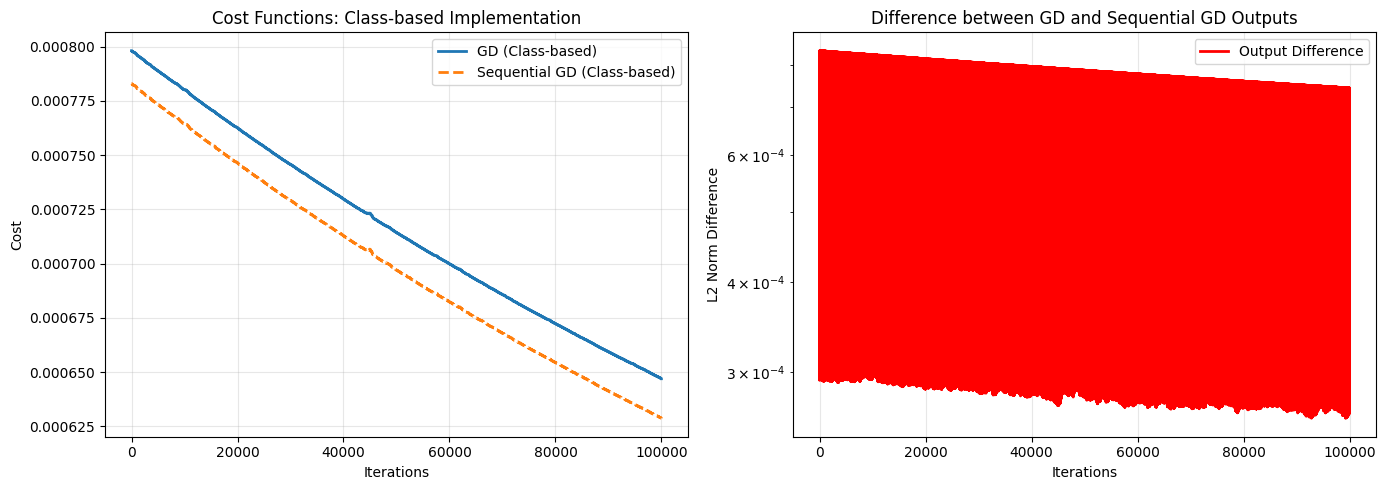


=== Training Statistics ===
Final Cost (GD): 0.000647
Final Cost (Seq GD): 0.000629
Final Output Difference: 0.000398


In [28]:
# ========== VISUALIZE TRAINING RESULTS ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot cost functions
axes[0].plot(cost_value_class, label='GD (Class-based)', linewidth=2)
axes[0].plot(cost_value_seq_class, linestyle='--', label='Sequential GD (Class-based)', linewidth=2)
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Cost')
axes[0].set_title('Cost Functions: Class-based Implementation')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot output differences
axes[1].plot(diff_output_class, label='Output Difference', color='red', linewidth=2)
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('L2 Norm Difference')
axes[1].set_title('Difference between GD and Sequential GD Outputs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.savefig('training_results_class_based.png', dpi=150)
plt.show()

# Print final statistics
print("\n=== Training Statistics ===")
print(f"Final Cost (GD): {cost_value_class[-1][0]:.6f}")
print(f"Final Cost (Seq GD): {cost_value_seq_class[-1][0]:.6f}")
print(f"Final Output Difference: {diff_output_class[-1][0]:.6f}")


Computing decision boundaries...


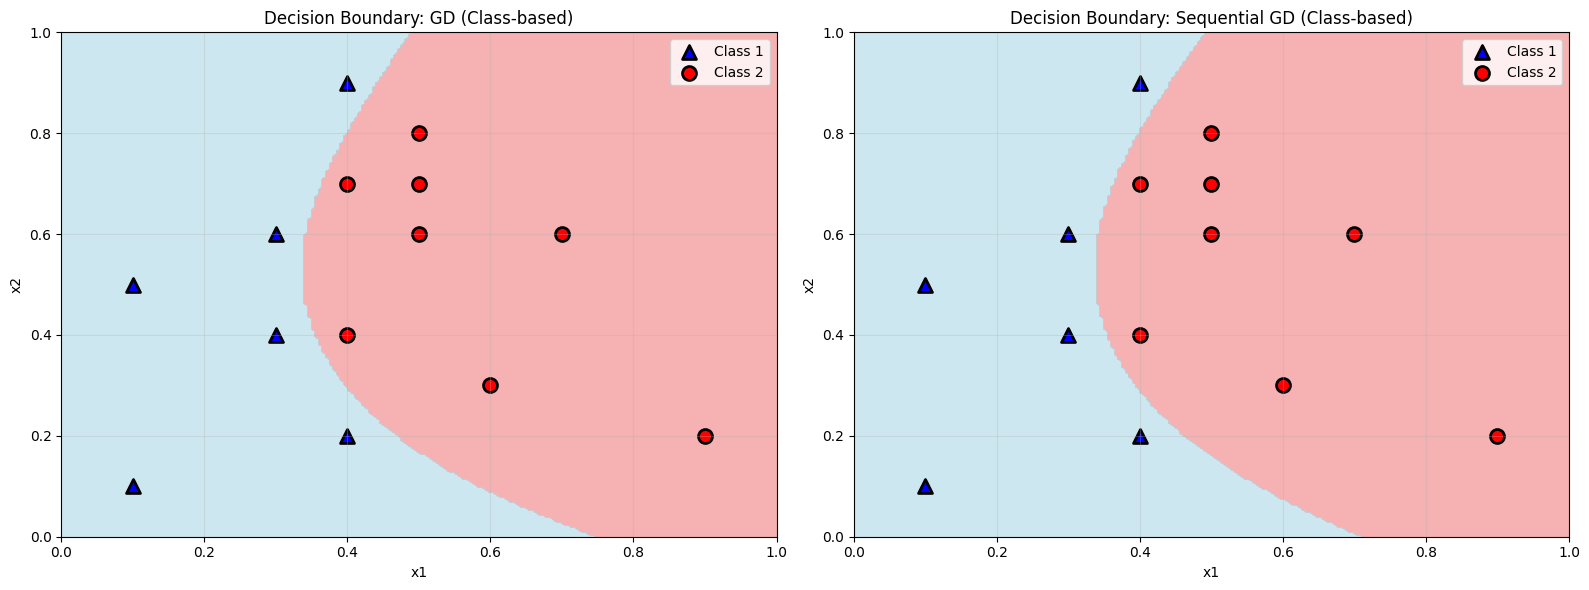

Decision boundaries computed and visualized!


In [29]:
# ========== DECISION BOUNDARY VISUALIZATION ==========
# Create a meshgrid for decision boundary visualization
X, Y = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))
X1Test = X.ravel()
X2Test = Y.ravel()

# Predictions for GD network
predictions_gd = np.zeros(200 * 200)
predictions_seq = np.zeros(200 * 200)

print("Computing decision boundaries...")
for i in range(len(X1Test)):
    xvec = np.array([[X1Test[i]], [X2Test[i]]])

    # GD predictions
    output_gd = nn_gd.predict(xvec)
    predictions_gd[i] = 1 if output_gd[0] >= output_gd[1] else 0

    # Sequential GD predictions
    output_seq = nn_seq.predict(xvec)
    predictions_seq[i] = 1 if output_seq[0] >= output_seq[1] else 0

YPred_gd = predictions_gd.reshape((200, 200))
YPred_seq = predictions_seq.reshape((200, 200))

# Plot decision boundaries
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# GD decision boundary
axes[0].contourf(X, Y, YPred_gd, levels=[0, 0.5, 1], colors=['lightcoral', 'lightblue'], alpha=0.6)
axes[0].scatter(x1[:6], x2[:6], marker='^', s=100, c='blue', edgecolors='black', linewidths=2, label='Class 1')
axes[0].scatter(x1[6:], x2[6:], marker='o', s=100, c='red', edgecolors='black', linewidths=2, label='Class 2')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_title('Decision Boundary: GD (Class-based)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sequential GD decision boundary
axes[1].contourf(X, Y, YPred_seq, levels=[0, 0.5, 1], colors=['lightcoral', 'lightblue'], alpha=0.6)
axes[1].scatter(x1[:6], x2[:6], marker='^', s=100, c='blue', edgecolors='black', linewidths=2, label='Class 1')
axes[1].scatter(x1[6:], x2[6:], marker='o', s=100, c='red', edgecolors='black', linewidths=2, label='Class 2')
axes[1].set_xlabel('x1')
axes[1].set_ylabel('x2')
axes[1].set_title('Decision Boundary: Sequential GD (Class-based)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('decision_boundaries_class_based.png', dpi=150)
plt.show()

print("Decision boundaries computed and visualized!")


## Example: Using Different Architectures

The `NeuralNetwork` class allows you to easily experiment with different architectures. Here are some examples:


In [ ]:
# ========== EXAMPLE: DIFFERENT ARCHITECTURES ==========
# You can easily create networks with different architectures

# Example 1: Simpler network (3 layers: 2 -> 4 -> 2)
simple_arch = [2, 4, 2]
nn_simple = NeuralNetwork(simple_arch, initialization='normal')
print(f"Simple architecture: {simple_arch}")
print(f"  {nn_simple}\n")

# Example 2: Deeper network (8 layers)
deep_arch = [2, 3, 4, 5, 6, 5, 4, 3, 2]
nn_deep = NeuralNetwork(deep_arch, initialization='xavier')  # Using Xavier initialization
print(f"Deep architecture: {deep_arch}")
print(f"  {nn_deep}\n")

# Example 3: Wide network (fewer layers, more neurons)
wide_arch = [2, 10, 10, 2]
nn_wide = NeuralNetwork(wide_arch, initialization='normal')
print(f"Wide architecture: {wide_arch}")
print(f"  {nn_wide}\n")

# Example 4: Test prediction with simple network
test_input = np.array([[0.5], [0.5]])
test_output = nn_simple.predict(test_input)
print(f"Test prediction (input: [0.5, 0.5]): {test_output.ravel()}")


In [9]:
# ========== DATA DEFINITION ==========
# Original Higham dataset with extensions
# Final dataset (from cell 8): 14 samples
# Class 1: [1, 0] - first 6 samples
# Class 2: [0, 1] - remaining 8 samples

# Final consolidated dataset (use this one)
x1 = np.array([0.3, 0.1, 0.3, 0.1, 0.4, 0.4, 0.6, 0.5, 0.9, 0.4, 0.7, 0.4, 0.5, 0.5])
x2 = np.array([0.6, 0.1, 0.4, 0.5, 0.9, 0.2, 0.3, 0.6, 0.2, 0.4, 0.6, 0.7, 0.7, 0.8])

n_samples = len(x1)
y = np.zeros((2, n_samples))
y[0, :6] = 1  # Class 1: first 6 samples
y[1, 6:] = 1  # Class 2: remaining samples

print(f"Dataset loaded: {n_samples} samples")
print(f"Class 1 samples: {np.sum(y[0, :])}")
print(f"Class 2 samples: {np.sum(y[1, :])}")


Dataset loaded: 14 samples
Class 1 samples: 6.0
Class 2 samples: 8.0


In [ ]:
# NOTE: Data definitions in cells 5-8 are now consolidated in cell 4 above.
# These cells are kept for reference but are no longer used.





In [10]:
#Added the first point as [1,0]
x1 = np.array([0.3,0.1, 0.3, 0.1, 0.4, 0.4, 0.6, 0.5, 0.9, 0.4, 0.7,0.4])
x2 = np.array([0.6,0.1, 0.4, 0.5, 0.9, 0.2, 0.3, 0.6, 0.2, 0.4, 0.6,0.7])

y           = np.zeros((2, 12))
y[0,:6] = np.ones((1,  6))
#y[0,5: ] = np.zeros((1, 5))
y[1,6: ] = np.ones((1,  6))


In [11]:
# Added the point (0.5,0.7) as [1,0]
x1 = np.array([0.3,0.1, 0.3, 0.1, 0.4, 0.4, 0.6, 0.5, 0.9, 0.4, 0.7,0.4,0.5])
x2 = np.array([0.6,0.1, 0.4, 0.5, 0.9, 0.2, 0.3, 0.6, 0.2, 0.4, 0.6,0.7,0.7])

y           = np.zeros((2, 13))
y[0,:6] = np.ones((1,  6))
#y[0,5: ] = np.zeros((1, 5))
y[1,6: ] = np.ones((1,  7))

In [12]:
# Added the point (0.5,0.8) as [1,0]
x1 = np.array([0.3,0.1, 0.3, 0.1, 0.4, 0.4, 0.6, 0.5, 0.9, 0.4, 0.7,0.4,0.5,0.5])
x2 = np.array([0.6,0.1, 0.4, 0.5, 0.9, 0.2, 0.3, 0.6, 0.2, 0.4, 0.6,0.7,0.7,0.8])

y           = np.zeros((2, 14))
y[0,:6] = np.ones((1,  6))
#y[0,5: ] = np.zeros((1, 5))
y[1,6: ] = np.ones((1,  8))

In [13]:
# prompt: print x1, x2, and y

print("x1:", x1)
print("x2:", x2)
print("y:\n", y)


x1: [0.3 0.1 0.3 0.1 0.4 0.4 0.6 0.5 0.9 0.4 0.7 0.4 0.5 0.5]
x2: [0.6 0.1 0.4 0.5 0.9 0.2 0.3 0.6 0.2 0.4 0.6 0.7 0.7 0.8]
y:
 [[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]]


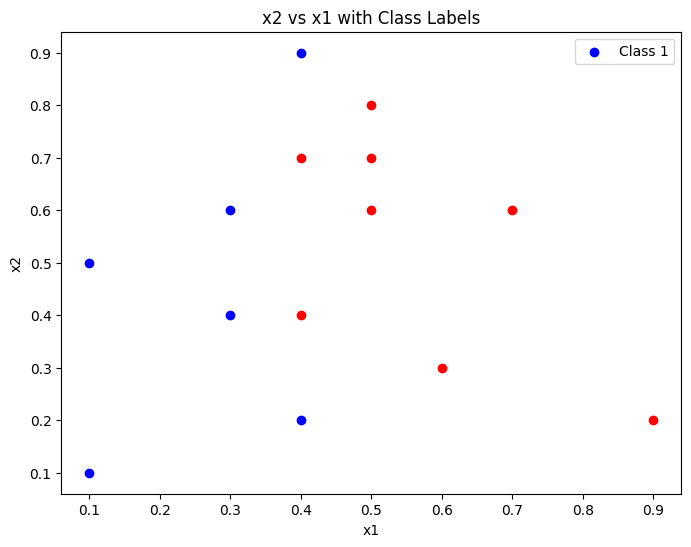

In [14]:
# prompt: plot x2 vs x1 and label them based on y

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(y.shape[1]):
  if y[0, i] == 1 and y[1, i] == 0:
    plt.scatter(x1[i], x2[i], color='blue', label='Class 1' if i == 0 else '')
  else:
    plt.scatter(x1[i], x2[i], color='red', label='Class 2' if i == 5 else '')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('x2 vs x1 with Class Labels')
plt.legend()
plt.show()


In [15]:
# ========== NETWORK ARCHITECTURE CONFIGURATION ==========
# Define the number of neurons in each layer
# Format: [input_size, layer2_size, layer3_size, ..., output_size]
# Current architecture: 2 input features -> 6 hidden layers -> 2 output classes

input_size = 2  # Number of input features (x1, x2)
layer_sizes = [30, 30, 30, 30, 30, 2]  # Number of neurons in layers 2, 3, 4, 5, 6, 7
# NOTE: The last element (Layer 7) MUST match output_size (currently 2)
output_size = 2  # Number of output classes

# Weight initialization parameters
weight_std = 0.5  # Standard deviation for weight initialization

print(f"Network Architecture:")
print(f"  Input: {input_size} features")
for i, size in enumerate(layer_sizes, start=2):
    print(f"  Layer {i}: {size} neurons")
print(f"  Output: {output_size} classes")
print(f"  Weight initialization std: {weight_std}")


Network Architecture:
  Input: 2 features
  Layer 2: 30 neurons
  Layer 3: 30 neurons
  Layer 4: 30 neurons
  Layer 5: 30 neurons
  Layer 6: 30 neurons
  Layer 7: 2 neurons
  Output: 2 classes
  Weight initialization std: 0.5


In [ ]:
W2,W3,W4 = normal(size=(2,2), scale=0.5), normal(size=(3,2), scale=0.5), normal(size=(2, 3), scale=0.5)
b2,b3,b4 = normal(size=(2,1), scale=0.5), normal(size=(3,1), scale=0.5), normal(size=(2, 1), scale=0.5)

# Weights for Sequential case
W2s,W3s,W4s = W2,W3,W4
b2s,b3s,b4s = b2,b3,b4


In [ ]:
# ========== WEIGHT AND BIAS INITIALIZATION ==========
# Automatically generate weights and biases based on layer_sizes configuration

# Create lists to store weights and biases
W_list = []
b_list = []

# Initialize weights and biases for each layer
prev_size = input_size  # Start with input size
for i, layer_size in enumerate(layer_sizes):
    # Weight matrix: (current_layer_size, previous_layer_size)
    W = normal(size=(layer_size, prev_size), scale=weight_std)
    # Bias vector: (current_layer_size, 1)
    b = normal(size=(layer_size, 1), scale=weight_std)

    W_list.append(W)
    b_list.append(b)
    prev_size = layer_size

# Unpack into individual variables for backward compatibility
W2, W3, W4, W5, W6, W7 = W_list
b2, b3, b4, b5, b6, b7 = b_list

# Weights for Sequential case (copy for sequential gradient descent)
W2s, W3s, W4s, W5s, W6s, W7s = W2.copy(), W3.copy(), W4.copy(), W5.copy(), W6.copy(), W7.copy()
b2s, b3s, b4s, b5s, b6s, b7s = b2.copy(), b3.copy(), b4.copy(), b5.copy(), b6.copy(), b7.copy()

print("Weights and biases initialized successfully!")
print(f"Total layers: {len(layer_sizes)}")


Weights and biases initialized successfully!
Total layers: 6


In [63]:
# Training hyperparameters
learning_rate = 0.1  # Learning rate for standard GD
learning_rate_seq = 0.1  # Learning rate for sequential GD
eta = learning_rate  # Keep for backward compatibility
eta_s = learning_rate_seq
Niter = 10000  # Number of training iterations
cost_calc_frequency = 1000  # Calculate full cost every N iterations (for efficiency)

In [64]:
xvec = np.zeros((2,1))
yvec = np.zeros((2,1))
cost_value = np.zeros((Niter,1))
cost_value_s = np.zeros((Niter,1))
diff_a7 = np.zeros((Niter,1))

for counter in np.arange(Niter):
    k = randint(y.shape[1])
    xvec[0,0], xvec[1,0] = x1[k], x2[k]
    yvec[:,0] = y[:, k]

    # forward pass
    a2 = activate(xvec, W2, b2)
    a2s = activate(xvec, W2s, b2s)
#    print("\n diff a2",a2-a2s)
#    time.sleep(1)
    a3 = activate(a2,   W3, b3)
    a3s = activate(a2s, W3s, b3s)
#    print("\n diff a3",a3-a3s)
#    time.sleep(1)
    a4 = activate(a3,   W4, b4)
    a4s = activate(a3s, W4s, b4s)
#    print("\n diff a4",a4-a4s)
#   time.sleep(1)
    a5 = activate(a4,   W5, b5)
    a5s = activate(a4s, W5s, b5s)

    a6 = activate(a5,   W6, b6)
    a6s = activate(a5s, W6s, b6s)

    a7 = activate(a6,   W7, b7)
    a7s = activate(a6s, W7s, b7s)

    # backward pass

    delta7 = a7 * (1 - a7) * (a7 - yvec)

    delta6 = a6 * (1 - a6) * np.dot(W7.T, delta7)

    delta5 = a5 * (1 - a5) * np.dot(W6.T, delta6)

    delta4 = a4 * (1 - a4) * np.dot(W5.T, delta5)

    delta3 = a3 * (1 - a3) * np.dot(W4.T, delta4)

    delta2 = a2 * (1 - a2) * np.dot(W3.T, delta3)


    delta7s = a7s * (1 - a7s) * (a7s - yvec)
    W7s = W7s - eta_s * delta7s * a6s.T
    b7s = b7s - eta_s * delta7s

    delta6s = a6s * (1 - a6s) * np.dot(W7s.T, delta7s)
    W6s = W6s - eta_s * delta6s * a5s.T
    b6s = b6s - eta_s * delta6s

    delta5s = a5s * (1 - a5s) * np.dot(W6s.T, delta6s)
    W5s = W5s - eta_s * delta5s * a4s.T  # FIXED: Changed from eta to eta_s for consistency
    b5s = b5s - eta_s * delta5s  # FIXED: Changed from eta to eta_s for consistency

    delta4s = a4s * (1 - a4s) * np.dot(W5s.T, delta5s)
    W4s = W4s - eta_s * delta4s * a3s.T
    b4s = b4s - eta_s * delta4s

    delta3s = a3s * (1 - a3s) * np.dot(W4s.T, delta4s)
    W3s = W3s - eta_s * delta3s * a2s.T
    b3s = b3s - eta_s * delta3s

    delta2s = a2s * (1 - a2s) * np.dot(W3s.T, delta3s)
    W2s = W2s - eta_s * delta2s * xvec.T
    b2s = b2s - eta_s * delta2s

    W2 -= eta * delta2 * xvec.T
    W3 -= eta * delta3 * a2.T
    W4 -= eta * delta4 * a3.T
    W5 -= eta * delta5 * a4.T
    W6 -= eta * delta6 * a5.T
    W7 -= eta * delta7 * a6.T
#    print("W2:\n",W2,"\n W2s:",W2s)
#    time.sleep(5)
    b2 -= eta * delta2
    b3 -= eta * delta3
    b4 -= eta * delta4
    b5 -= eta * delta5
    b6 -= eta * delta6
    b7 -= eta * delta7

    cost_value[counter] = cost_function(W2,W3,W4,W5,W6,W7,b2,b3,b4,b5,b6,b7,x1, x2, y)
    cost_value_s[counter] = cost_function(W2s,W3s,W4s,W5s,W6s,W7s,b2s,b3s,b4s,b5s,b6s,b7s,x1, x2, y)
    diff_a7[counter] = np.linalg.norm(a7.ravel()-a7s.ravel(),2)

NameError: name 'W2' is not defined

In [ ]:
# prompt: print W2 and W2s side by side

print("W2:\n", W2, "\nW2s:\n", W2s)


In [ ]:
# prompt: print the last 5 elements of cost_value

print(cost_value[-5:])
print(cost_value_s[-5:])
print(diff_a7[-5:])


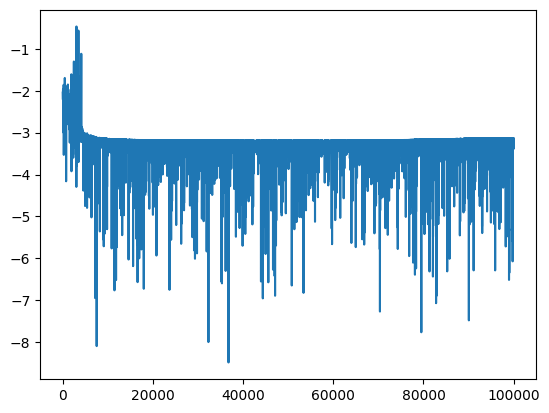

In [ ]:
plt.plot(cost_value-cost_value_s)
plt.savefig('cost_difference.png')
plt.show()


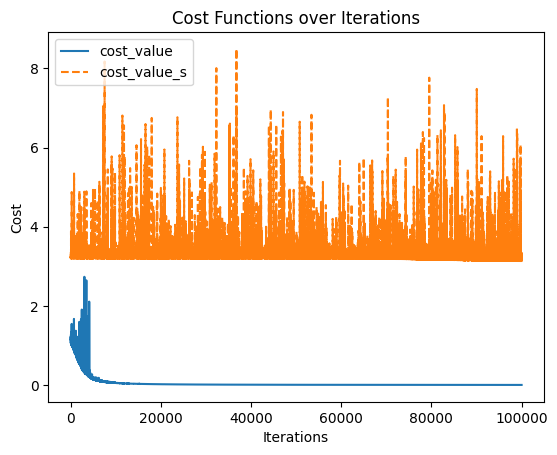

In [ ]:
# prompt: plot cost_value and cost_value_s in the same graph with a dashed line for cost_value_s

plt.plot(cost_value, label='cost_value')
plt.plot(cost_value_s, linestyle='--', label='cost_value_s')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Functions over Iterations')
plt.legend()
plt.savefig('cost_functions.png')
plt.show()


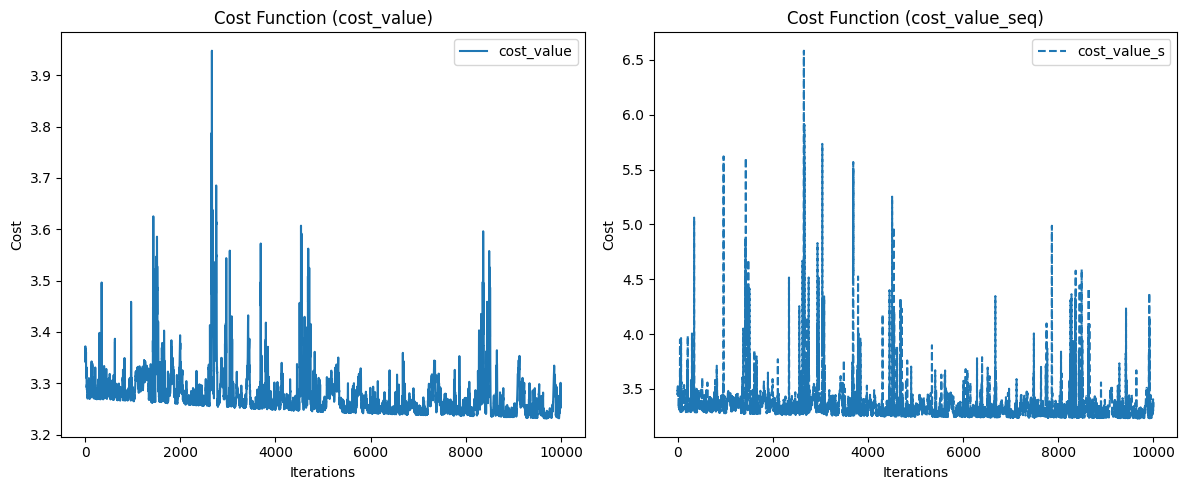

In [ ]:
# prompt: plot cost_value and cost_value_s in two graphs side by side

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(cost_value, label='cost_value')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Cost')
axes[0].set_title('Cost Function (cost_value)')
axes[0].legend()

axes[1].plot(cost_value_s, linestyle='--', label='cost_value_s')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Cost')
axes[1].set_title('Cost Function (cost_value_seq)')
axes[1].legend()

plt.tight_layout()
plt.savefig('cost_function_subplots.png')
plt.show()

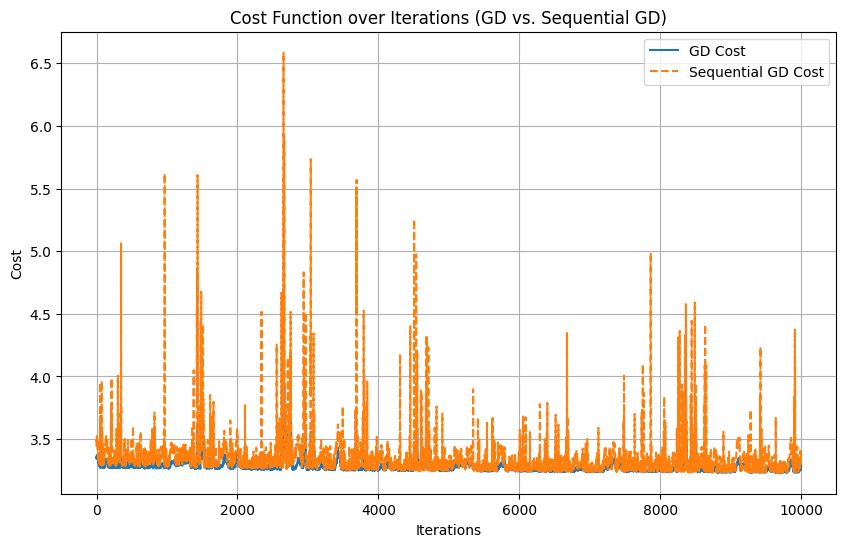

In [ ]:
# prompt: plot cost_value and cost_value_s in the same graph

plt.figure(figsize=(10, 6))
plt.plot(cost_value, label='GD Cost')
plt.plot(cost_value_s, linestyle='--', label='Sequential GD Cost')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Function over Iterations (GD vs. Sequential GD)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
X, Y = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))

X1Test = np.array(X.ravel())
X2Test = np.array(Y.ravel())

XTest  = np.stack((X1Test, X2Test), axis = 1)
empty  = np.zeros(200*200)
empty_s  = np.zeros(200*200)

# print(X)

In [ ]:
for i in np.arange(XTest.shape[0]):

    xvec[0,0], xvec[1,0] = XTest[i, 0], XTest[i, 1]


    YPredictions = predict(W2, W3, W4, W5, W6, W7, b2, b3, b4, b5, b6, b7, xvec)
    YPredictions = np.array(YPredictions[0] >= YPredictions[1])

    YPredictions_s = predict(W2s,W3s,W4s,W5s,W6s,W7s,b2s,b3s,b4s,b5s,b6s,b7s,xvec)
    YPredictions_s = np.array(YPredictions_s[0] >= YPredictions_s[1])



    if YPredictions[0] == True:
        empty[i] = 1

    if YPredictions_s[0] == True:
        empty_s[i] = 1


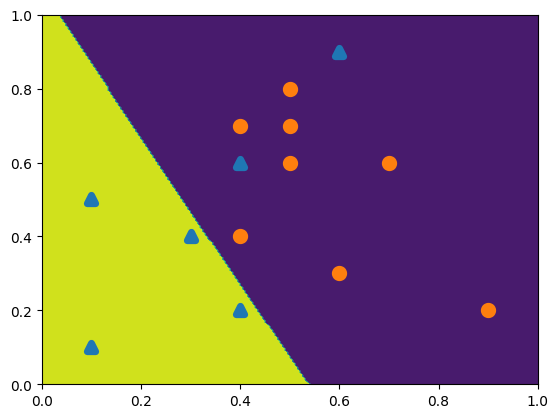

In [ ]:
YPred = empty.reshape((200, 200))
YPred_s = empty_s.reshape((200, 200))

import matplotlib.pyplot as plt
plt.figure()
# plt.imshow(YPred)
plt.contourf(X, Y, YPred)

plt.scatter(x1[0:6], x2[0:6], marker='^', lw=5)
plt.scatter(x1[6:],  x2[6:], marker='o', lw=5)
plt.show()

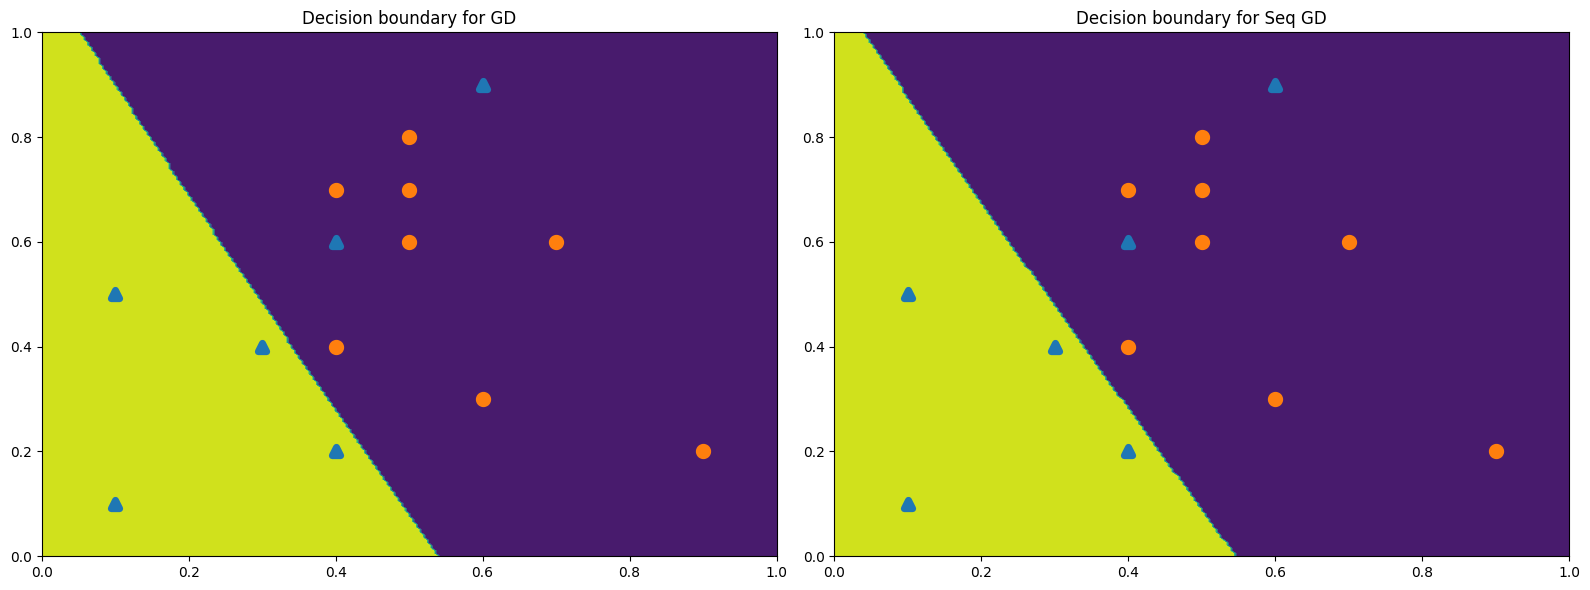

In [ ]:
# prompt: set the two figures above one next to the other

import matplotlib.pyplot as plt

# Assuming YPred and YPred_s are already defined from the previous code

plt.figure(figsize=(16, 6))  # Adjust the figure size as needed

plt.subplot(1, 2, 1)  # Create a subplot for the first figure (sequential)
plt.contourf(X, Y, YPred)

plt.scatter(x1[0:6], x2[0:6], marker='^', lw=5)
plt.scatter(x1[6:],  x2[6:], marker='o', lw=5)
# plt.scatter(x1, x2, c=y[0, :],marker='^', lw=5)
plt.title("Decision boundary for GD")
plt.savefig('decision_boundary_GD.png')


plt.subplot(1, 2, 2)  # Create a subplot for the second figure (parallel)
plt.contourf(X, Y, YPred_s)
plt.scatter(x1[0:6], x2[0:6], marker='^', lw=5)
plt.scatter(x1[6:],  x2[6:], marker='o', lw=5)
plt.title("Decision boundary for Seq GD")
#plt.savefig('decision_boundaries_Seq_GD.png')

plt.tight_layout()  # Adjust spacing between subplots
plt.savefig('decision_boundaries.png')
plt.show()
